### Обучение однослойного персептрона методом коррекции по ошибке через дельта-правило


### Загрузка датасета, предобработка данных

In [65]:
PATH = 'C:/Users/Mikasi/Desktop/ИНСТ 06.2022/Technologies of deep learning and neural networks (Gorodnichev)'

import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.Resize(28),
                                transforms.ToTensor()])

train_dataset = datasets.ImageFolder(PATH+'/Train', transform=transform)
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=24, shuffle=True)
images, labels = next(iter(dataloader))

Наши картинки имеют по 3 канала, но использование всех 3 в данной задаче излишне - можно выбрать любой канал.

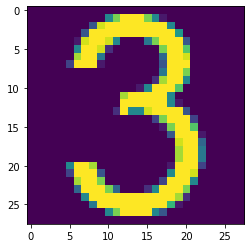

In [66]:
plt.imshow(images[0][0])

In [67]:
images = images[:, 0]
images = images.reshape(24, 28*28)

### Архитектура сети:

Создадим однослойный персептрон. \\

Входной слой: 784 x 1 \\

Метод обучения: дельта-правило (см. torch.optim.Adadelta)


In [68]:
import torch
from torch.nn import Linear

In [69]:
input_size = 784
output_size = 1

In [70]:
mlp = torch.nn.Sequential(
    Linear(input_size, output_size)
).to('cuda')

loss_fn = torch.nn.MSELoss()
learning_rate = 0.001
optimizer = torch.optim.Adadelta(mlp.parameters(), lr=learning_rate)
num_epoch = 5000

In [138]:
train_data = torch.cuda.FloatTensor(images.numpy(), device='cuda')
train_labels = torch.cuda.FloatTensor(labels.numpy(), device='cuda')

loss_curve = []
for epoch in range(num_epoch):
    y_pred = mlp(train_data)
    loss = loss_fn(y_pred.reshape(-1), train_labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 60 == 0:

        print('Epoch:', epoch, 'Loss:', loss.item())
        loss_curve.append(loss.item())
    

Epoch: 0 Loss: 1.1178818287715941e-10
Epoch: 60 Loss: 1.1148439116315245e-10
Epoch: 120 Loss: 1.1123067744644999e-10
Epoch: 180 Loss: 1.102125751772931e-10
Epoch: 240 Loss: 1.0983868675706887e-10
Epoch: 300 Loss: 1.0939282812927331e-10
Epoch: 360 Loss: 1.0891042234728587e-10
Epoch: 420 Loss: 1.0800327299165247e-10
Epoch: 480 Loss: 1.0836148645054777e-10
Epoch: 540 Loss: 1.0851915199783235e-10
Epoch: 600 Loss: 1.0731593391710703e-10
Epoch: 660 Loss: 1.0682615209089974e-10
Epoch: 720 Loss: 1.0632338759419824e-10
Epoch: 780 Loss: 1.0582143494808349e-10
Epoch: 840 Loss: 1.05564834651517e-10
Epoch: 900 Loss: 1.05221185930926e-10
Epoch: 960 Loss: 1.0479508233407486e-10
Epoch: 1020 Loss: 1.0461188859611781e-10
Epoch: 1080 Loss: 1.0419267532091325e-10
Epoch: 1140 Loss: 1.0422179785862795e-10
Epoch: 1200 Loss: 1.0423961693817319e-10
Epoch: 1260 Loss: 1.0250743309736521e-10
Epoch: 1320 Loss: 1.0265312905266555e-10
Epoch: 1380 Loss: 1.0211059081610685e-10
Epoch: 1440 Loss: 1.0147829104800721e-10


Text(0, 0.5, 'loss')

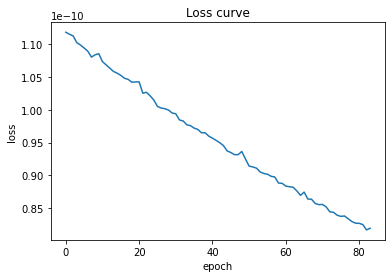

In [139]:
from matplotlib import pyplot as plt

plt.plot(loss_curve)
plt.title('Loss curve')
plt.xlabel('epoch')
plt.ylabel('loss')

In [140]:
from sklearn.metrics import accuracy_score

preds = y_pred.detach().cpu().numpy().round()
print("Точность на обучении:", accuracy_score(train_labels.detach().cpu().numpy(), preds))

Точность на обучении: 1.0


## Тестирование:

In [141]:
test_dataset = datasets.ImageFolder(PATH+'/Test', transform=transform)
dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)
test_images, test_labels = next(iter(dataloader))

test_images = test_images[:, 0]
test_images = test_images.reshape(6, 28*28)

In [142]:
test_data = torch.cuda.FloatTensor(test_images.numpy(), device='cuda')
test_preds = mlp(test_data).detach().cpu().numpy().round()

In [143]:
print("Точность на тесте:", accuracy_score(test_labels.numpy(), test_preds))

Точность на тесте: 0.8333333333333334


### Где ошибка?

In [144]:
test_labels = test_labels.numpy().astype(int)
test_preds = test_preds.reshape(-1).astype(int)

In [145]:
wrong_ans = test_preds != test_labels
bad_classification_X = test_data[wrong_ans]
wrong_preds = test_preds[wrong_ans]

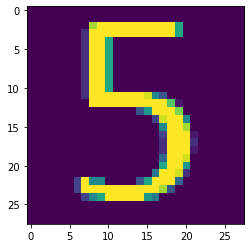

In [146]:
plt.imshow(bad_classification_X.cpu().detach().numpy().reshape(28, 28))

In [149]:
print("Модель считает, что это :", wrong_preds[0])

Модель считает, что это : 4


## Выводы:

Сеть данной архитектуры способна решать данную задачу просто как задачу регрессии, что говорит о том, что изображения цифр оказались хорошо линейно разделимы в пространстве векторов размера 784. \\

Однако вряд ли у нашей сети есть серъезная способность к генерализации - на столь малом датасете такие выводы делать не стоит. Скорее всего сеть просто переобучилась на тренировочную выборку (что видно по лосс-кривой), и может выдавать ответы только на данных, очень похожих на тренировочные.